In [1]:
#!/usr/bin/env python
# coding: utf-8




import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow import keras
from time import localtime, strftime
import tensorflow as tf
import kerastuner as kt
import statistics






def getAllData(targetVar, path):
    
    df = pd.read_csv(path)
    
    print(df.columns)
    

    col = df.columns.tolist()
    
    col.remove(targetVar)
    
    col += [targetVar] 
     
    return df[col]


def splitDataOnMonths(df):
    """Splits a dataframe into train, validation and test dataframes. 
    The data is split on specific months to avoid temporal overlapping.
    """

    maxMonth = df["month"].max()
    
    #GLOBALT
    
    #(start, stop)
    #trainMonths = (0, 264)
    
    #valMonths = (265, 300)
    
    #testMonths = (301, 336)
    
    ##AFRIKA
    
    trainMonths = (0, 287)
    
    valMonths = (288, 323)
    
    testMonths = (324, 359)
    
    
    def getMonthsBetween(df, start, stop):
        return df[(df["month"] >= start) & (df["month"] <= stop) ]
    
    
    train_df = getMonthsBetween(df, trainMonths[0], trainMonths[1])
    test_df = getMonthsBetween(df, testMonths[0], testMonths[1])
    val_df = getMonthsBetween(df, valMonths[0], valMonths[1])
    
    print(train_df)
    print(val_df)
    print(test_df)
    
    return train_df, test_df, val_df

    

 
 #%%
def df_to_timeseriesMatrix(df, windowSize, nShifts, targetVar):
    """Creates time series matrix appropiate for supervised learning.
    """

    #Tilldelar Y målvariablen.
    Y = df[targetVar] 
    
    #Tar bort målvariablen från resten av datasetet
    col = df.columns.tolist()
    col.remove(targetVar)
    df = df[col]
    
    
    #Antalet attribut/variabler
    n_variables = len(df.columns)
   
    
    
    cols, names = list(), list()
    
	
    #Skapar tidsseriematrisen
    for i in range(windowSize, 0, -1):
        cols.append(df.shift(i))
        names += [('var{0}(t-{1})'.format(j+1, i-1)) for j in range(n_variables)]
	
    #Om shifts är mindre än eller lika med noll så kommer den inte shifta. Men är minst shiftad 1. 
    if nShifts <= 0:
        nShifts = -1
    
    
    #Siftar Y så många steg in i framtiden som ska predikteras
    Y = Y.shift(-nShifts+1)
    
    #Lägger till Y i matrisen
    cols.append(Y)
    names+=["Y"]
    
	# sätt ihop
    agg = concat(cols, axis=1)
    agg.columns = names
    
    #sortera
    #agg = agg.sort_index(axis=1, ascending=False)
    
    #Ta bort windowSize första raderna (som har minst en NaN)
    agg.dropna(inplace=True)

    return agg



def createNsplitTimeMatrix(df, windowSize, nShifts, targetVar):
    """Splits a time series matrix in predictors and target values.
    """
    matrix = df_to_timeseriesMatrix(df, windowSize, nShifts, targetVar)
    

    dataY = matrix["Y"].values
    matrix = matrix.drop(columns=["Y"])
    dataX = matrix.values

    return dataX, dataY





def restructureData(df, windowSize, nShifts, targetVar):
    """Splits a dataframe into predictors X, and target values Y. 
    Every country is made into samples one by one to avoid spatial overlapping. 
    The target values are shifted nShift times.
    
    """
    countryMax = df["country_id"].max()

    X = np.array([])
    Y = np.array([])
    flag = 0
    countries = list(set(df["country_id"].values))
    
    for c_id in countries:
        df_single_country = df[df["country_id"] == c_id]
        c_X, c_Y = createNsplitTimeMatrix(df_single_country, windowSize, nShifts, targetVar)
        
        if flag == 0:
            X = c_X
            Y = c_Y
            flag = 1
        else:
            X = np.concatenate((X, c_X))
            Y = np.concatenate((Y, c_Y))
        
 
    return X, Y
       
    




def buildModel(hiddenLayers, unitsPerHL, unitsInputLayer, batch_size=32): 
    """Builds the model.
    """
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auroc', curve='ROC'),
      keras.metrics.AUC(name='aupr', curve='PR'),

]
    
    #optimizer
    ADAM = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-6, amsgrad=False,
    name='Adam'
    )
    
    
    
    model = keras.models.Sequential()
    
    #storlekn på antal features
    #input layer
    model.add(keras.layers.Dense(unitsInputLayer, activation='relu', batch_size=batch_size))
    
    #hidden layers
    for i in range(hiddenLayers):
        model.add(keras.layers.Dense(unitsPerHL, activation='relu',batch_size=batch_size))
        

    #Output layers
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=ADAM, loss='binary_crossentropy', metrics=METRICS)
    
    return model


def build_tuner_model(hp):
    """Tuner function. Is used to find the optimal hyperparameters. 
    Max and min values for hyperparameters needs to be changed here.
    """
    #min, max, step
    #unitsInput = hp.Int('unitsInputLayer', 4, 15, step=2)
    unitsHL = hp.Int('unitsPerHL', 4, 11, step=1)
    hiddenLayers = hp.Int('hiddenLayers', 1, 5, step=1)
    #batch size
    bs = hp.Int('batch_size', 16, 40, step=4)
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auroc', curve='ROC'),
      keras.metrics.AUC(name='aupr', curve='PR'),

    ]
    
    #optimizer
    ADAM = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-6, amsgrad=False,
    name='Adam'
    )

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(unitsHL, activation='relu', batch_size=bs))
    
    for i in range(hiddenLayers):
        
        model.add(keras.layers.Dense(unitsHL, activation='relu',batch_size=bs))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=ADAM,loss='binary_crossentropy',metrics=METRICS)
    
    return model


def fitModel(model, trainX, trainY, valX, valY, epo, batch_size,  shuffle=False):
    """Fit model. Returns model and metric history.
    """
    # fit network
    history = model.fit(x=trainX, y=trainY,  validation_data=(valX, valY), epochs=epo, verbose=2, shuffle=shuffle, batch_size=batch_size)
    
    return model, history




def predictModel(model, testX, nShifts, batch_size):
    """Precit model
    """
    
    print(testX.shape)
    res = model.predict(testX, batch_size=batch_size)
    
    return res



def plotPredict(res, testY, nShifts, windowSize, epochs, hiddenLayers, unitsPerHL, unitsInputLayer, batch_size, timeStamp, shuffle, onlyAfricaTest, onlyAfricaVal, onlyAfricaTrain) :
    """Plot predicitons and actual data. The hyperparameters that were used is shown at the top.
    """
    
    windowStart = 0
    windowsStop = 205
    predictStart = 130 - windowStart
    predVal = testY[windowsStop:windowsStop+nShifts]    
    
    predVal_plot  = np.append(np.array([np.nan]*(windowsStop-windowStart)), predVal)
    res_plot = np.append(np.array([np.nan]*(predictStart-1)), res.tolist())
    
    
    print("Y-shape: "+ str(testY.shape))
    #testY = testY[nShifts:]
    
    plt.plot(res_plot, "+r", label='prediction')
    plt.plot(testY[windowStart:windowsStop], label='actual')
    plt.plot(predVal_plot, label="future val")
    
    plt.xlabel('Steps (months?)')
    plt.ylabel('Prob. of conflict')
    
    title = "{0}\n nShifts: {1} windowSize: {2} epochs: {3}\n  hiddenLayers: {4}  unitsPerHL: {5}  unitsInputLayer: {6} \n batch_size: {7} shuffle: {8} \n onlyAfricaTest: {9} onlyAfricaVal: {10} onlyAfricaTrain: {11}".format(timeStamp, nShifts, windowSize, epochs, hiddenLayers, unitsPerHL, unitsInputLayer, batch_size, shuffle, onlyAfricaTest, onlyAfricaVal, onlyAfricaTrain)
  
    plt.title(title)
   
    plt.legend()
    plt.show()



def plotMetrics(history, timeStamp):
    """Plot metrics from fitting.
    """
    #print(history.history.keys())
    auroc = history.history['auroc']
    val_auroc = history.history['val_auroc']
    
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    aupr = history.history['aupr']
    val_aupr = history.history['val_aupr']
    
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(auroc, label="Training", color="g")
    axs[0, 0].plot(val_auroc, label="Validation")
    axs[0, 0].set_title("AUROC")
    
    
    axs[1, 0].plot(precision, color="g")
    axs[1, 0].plot(val_precision)
    axs[1, 0].set_title("Precision")
    
    #axs[0, 1].plot(accuracy, color="g")
    #axs[0, 1].plot(val_accuracy)
    #axs[0, 1].set_title("Accuracy")
    
    axs[0, 1].plot(aupr, color="g")
    axs[0, 1].plot(val_aupr)
    axs[0, 1].set_title("AUPR")
    
    axs[1, 1].plot(loss, color="g")
    axs[1, 1].plot(val_loss)
    axs[1, 1].set_title("Loss")
    fig.legend()
    fig.suptitle(timeStamp)
    
    fig.tight_layout()

def getEvaluateMetric(model, score):
    """Create dictionary of metric score and metric name from the model.evaluate method.
    """
    
    metrics = {}
    for metric_name, value in zip(model.metrics_names, score):
        metrics[metric_name] = value
        
    return metrics

def getAverageFitMetric(history):
    
    mean_metrics = {}
    for key in history.history.keys():
        mean_metrics[key] = statistics.mean(history.history[key])
        
    return mean_metrics

def calcBrierScore(results, testY):
    
    brierPerPrediction = []
    results = [r for sublist in results for r in sublist]
    
    for p, v in zip(results, testY):
        brier = (p-v)**2
        brierPerPrediction.append(brier)
    
        
    return statistics.mean(brierPerPrediction)
    
    
    
def onlyAfricaFilter(df, only=False):
    """Filter dataframe on countries outside of africa.
    """
    if only:
        df = df.loc[(df['e_regiongeo'] == 5) | (df['e_regiongeo'] == 6) | (df['e_regiongeo'] == 7)| (df['e_regiongeo'] == 8)| (df['e_regiongeo'] == 9)]
        #Resets row indexing.
        df = df.reset_index(drop=True)

    return df
    

#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
def saveModel(model, name):
    """Save model.
    """
    model_json = model.to_json()
    with open(str(name)+".json", "w") as json_file:
        json_file.write(model_json)
        
 
    model.save_weights(str(name)+".h5")
    print("Model saved")



def loadModel(name):
    """Load saved model.
    """
    
    
    json_file = open(str(name)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.model_from_json(loaded_model_json)

    model.load_weights(str(name)+".h5")
    
    return model, args_text


def saveArgs(name, args):
    f = open("{0}_args.txt".format(name),"w+")
    f.write(str(args))
    
def loadArgs(name):
    f = open("{0}_args.txt".format(name),"r")
    args_text = f.read()
    return args_text


#%%

def runModel(args):
    targetVar = args["targetVar"]
    onlyAfricaTest = args["onlyAfricaTest"]
    onlyAfricaVal = args["onlyAfricaVal"]
    onlyAfricaTrain = args["onlyAfricaTrain"]
    windowSize = args["windowSize"]
    nShifts = args["nShifts"]
    epochs = args["epochs"]
    hiddenLayers = args["hiddenLayers"]
    unitsPerHL = args["unitsPerHL"]
    unitsInputLayer = args["unitsInputLayer"]
    shuffle = args["shuffle"]
    batch_size = args["batch_size"]
    timeStamp = args["timeStamp"]
    
    
    #Fetch data
    df = getAllData(targetVar, path)
    
    #Remove the last two years. ViEWS test period is ending dec 2016.
    #df = df[df["month"] <= 336]
    
    print(df.columns)

    #Split in train, test, val
    train_df, test_df, val_df = splitDataOnMonths(df)
    
    #Filter data on africa
    test_df = onlyAfricaFilter(test_df, onlyAfricaTest)
    val_df = onlyAfricaFilter(val_df, onlyAfricaTest)
    train_df = onlyAfricaFilter(train_df, onlyAfricaTrain)
    
    #Remove 'month'-column
    train_df = train_df.drop(columns=["month"])
    val_df = val_df.drop(columns=["month"])
    test_df = test_df.drop(columns=["month"])
    
    
    
    #Same scaler for all three data sets. 
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    #Create training set
    trainX, trainY = restructureData(train_df, windowSize, nShifts, targetVar)
    print("Training set: Done "+ str(trainX.shape))
    
    #Normalize
    trainX_scaled = scaler.fit_transform(trainX)
   
    #Create val set
    valX, valY = restructureData(val_df, windowSize, nShifts, targetVar)
    print("Val set: Done "+ str(valX.shape))
    
    #Normalize
    valX_scaled = scaler.transform(valX)
    
    #Create test set
    testX, testY = restructureData(test_df, windowSize, nShifts, targetVar)
    print("Test set: Done "+ str(testX.shape))
    
    #Normalize
    testX_scaled = scaler.transform(testX)
    
    #Tune network by finding optimal hyperparameters. 
    if args["kerasTuner"]:
        
        max_epochs = 100
        
        hp = kt.HyperParameters()      
        
        tuner = kt.Hyperband(build_tuner_model,'val_loss',max_epochs,hyperband_iterations=2)

        tuner.search(trainX_scaled, trainY,validation_data=(valX_scaled, valY))
        
        hyperp = tuner.get_best_hyperparameters()
       
        tuner.results_summary()
        
        return False, False

      
    else:
        #Normal run
        #Build
        model_1 = buildModel(hiddenLayers, unitsPerHL, unitsInputLayer, batch_size)
        #Fit
        model_1, history = fitModel(model_1, trainX_scaled, trainY, valX_scaled, valY, epochs, batch_size, shuffle=shuffle)
        
        #Print nework structure
        model_1.summary()
        
        
        test_eval = model_1.evaluate(testX_scaled, testY, batch_size=batch_size)
        
        #Predict.
        res1 = predictModel(model_1, testX_scaled, nShifts, batch_size)
        
        #Plot predicitons. 
        #plotPredict(res1, testY, nShifts, windowSize, epochs, hiddenLayers, unitsPerHL, unitsInputLayer, batch_size, timeStamp, shuffle, onlyAfricaTest, onlyAfricaVal, onlyAfricaTrain)
        
        #Plot metrics.
        plotMetrics(history, timeStamp)
        #print(args)
        
        #print(getAverageFitMetric(history))
        
        #print(getEvaluateMetric(model_1, test_eval))
        
        #print("\n BRIER:\n")
        
        #print(calcBrierScore(res1, testY))
        
        metrics = {"Brier": calcBrierScore(res1, testY), "Metrics": getEvaluateMetric(model_1, test_eval)}
        
        return model_1, metrics
    




path = "X:/Exjobb/MOPS/data/processed/full_dataset.csv"
#path = "C:/Users/Henrik/Downloads/full_dataset.csv"








In [ ]:
getAllData("dummy_type_1", path)["month"]

In [ ]:

args_mindre_modell = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 5,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}


model_1, metrics_1 = runModel(args_mindre_modell)
metrics_1

In [ ]:
{'Brier': 0.10569832246252957,
 'Metrics': {'loss': 0.4022343392307718,
  'tp': 181.0,
  'fp': 11.0,
  'tn': 1098.0,
  'fn': 194.0,
  'accuracy': 0.86185986,
  'precision': 0.9427083,
  'recall': 0.48266667,
  'auroc': 0.9120818,
  'aupr': 0.84428316}}


In [ ]:




args_t3_sb_G = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_3, metrics_3 = runModel(args_t3)
metrics_3

In [ ]:
args_t6_sb_G = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_sb_G, metrics_t6_sb_G = runModel(args_t6_sb_G)
metrics_t6_sb_G

In [ ]:
args_t9_sb_G = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 9,
        #Antalet förskjutningar.
        "nShifts" : 9, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t9_sb_G, metrics_t9_sb_G = runModel(args_t9_sb_G)
metrics_t9_sb_G

In [ ]:
args_t12_sb_G = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_sb_G, metrics_t12_sb_G = runModel(args_t12_sb_G)
metrics_t12_sb_G

_________TYP 2 (os)

In [ ]:
args_t3_os_G = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t3_os_G, metrics_t3_os_G = runModel(args_t3_os_G)

name = "model_t3_os_G"
saveArgs(name, (args_t3_os_G, metrics_t3_os_G ))
metrics_t3_os_G

In [ ]:
args_t6_os_G = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_os_G, metrics_t6_os_G = runModel(args_t6_os_G)

name = "model_t6_os_G"
saveArgs(name, (args_t6_os_G, metrics_t6_os_G ))
metrics_t6_os_G

In [ ]:
args_t9_os_G = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 9,
        #Antalet förskjutningar.
        "nShifts" : 9, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t9_os_G, metrics_t9_os_G = runModel(args_t9_os_G)

name = "model_t9_os_G"
saveArgs(name, (args_t9_os_G, metrics_t9_os_G ))
metrics_t9_os_G

In [ ]:
args_t12_os_G = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 9,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_os_G, metrics_t12_os_G = runModel(args_t12_os_G)

name = "model_t12_os_G"
saveArgs(name, (args_t12_os_G, metrics_t12_os_G ))
metrics_t12_os_G

 _________ TYPE 3 (ns)

In [ ]:
args_t3_ns_G = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t3_ns_G, metrics_t3_ns_G = runModel(args_t3_ns_G)

name = "model_t3_ns_G"
saveArgs(name, (args_t3_ns_G, metrics_t3_ns_G ))
metrics_t3_ns_G

In [ ]:
args_t6_ns_G = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_ns_G, metrics_t6_ns_G = runModel(args_t6_ns_G)

name = "model_t6_ns_G"
saveArgs(name, (args_t6_ns_G, metrics_t6_ns_G ))
metrics_t6_ns_G

In [ ]:
args_t9_ns_G = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 9,
        #Antalet förskjutningar.
        "nShifts" : 9, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t9_ns_G, metrics_t9_ns_G = runModel(args_t9_ns_G)

name = "model_t9_ns_G"
saveArgs(name, (args_t9_ns_G, metrics_t9_ns_G ))
metrics_t9_ns_G

In [ ]:
args_t12_ns_G = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 9,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_ns_G, metrics_t12_ns_G = runModel(args_t12_ns_G)

name = "model_t12_ns_G"
saveArgs(name, (args_t12_ns_G, metrics_t12_ns_G ))
metrics_t12_ns_G

AFRIKA--------------------------------------------------

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_2', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_1'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (47310, 87)
Val set: Done (1749, 87)
Test set: Done (1749, 87)
Train on 47310 samples, validate on 1749 samples
Epoch 1/7
47310/47310 - 7s - loss: 0.2866 - tp: 3692.0000 - fp: 1898.0000 - tn: 38417.0000 - fn: 3303.0000 - accuracy: 0.8901 - precision: 0.6605 - recall: 0.5278 - auroc: 0.8773 - aupr: 0.6450 - val_loss: 0.2972 - val_tp: 256.0000 - val_fp: 64.0000 - val_tn: 1290.0000 - val_fn: 139.0000 - val_accuracy: 0.8839 - val_precision: 0.8000 - val_recall: 0.6481 - val_auroc: 0.9149 - val_aupr: 0.8051
Epoch 2/7
47310/47310 - 2s - loss: 0.2114 - tp: 4630.0000 - fp: 1572.0000 - tn: 38743.0000 - fn: 2365.0000 - accuracy: 0.9168 - precision: 0.7465 - recall: 0.6619 - auroc: 0.9300 - aupr: 0.7831 - val_loss: 0.2868 - val_tp: 263.0000 - val_fp: 69.0000 - val_tn: 1285.0000 - val_fn: 132.0000 - val_accuracy: 0.8851 - val_precision: 0.7922 - val_recall: 0.6658 - val_auroc: 0.9179 - val_aupr: 0.8119
Epoch 3/7
47310/47310 - 3s - loss: 0.1914 - tp: 4695

{'Brier': 0.06819956428265694,
 'Metrics': {'loss': 0.24251168670336168,
  'tp': 309.0,
  'fp': 22.0,
  'tn': 1291.0,
  'fn': 127.0,
  'accuracy': 0.91480845,
  'precision': 0.93353474,
  'recall': 0.7087156,
  'auroc': 0.942526,
  'aupr': 0.90257144}}

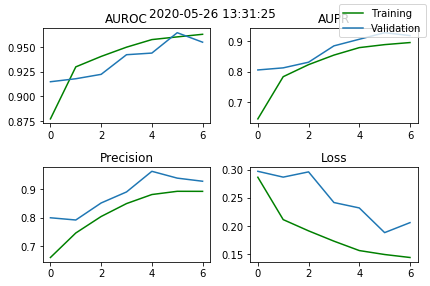

In [2]:



args_t1_sb_A = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 1, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t1_sb_A, metrics_t1_sb_A = runModel(args_t1_sb_A)
metrics_t1_sb_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_2', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_1'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (46480, 87)
Val set: Done (1484, 87)
Test set: Done (1484, 87)
Train on 46480 samples, validate on 1484 samples
Epoch 1/6
46480/46480 - 7s - loss: 0.2742 - tp: 3575.0000 - fp: 1793.0000 - tn: 37820.0000 - fn: 3292.0000 - accuracy: 0.8906 - precision: 0.6660 - recall: 0.5206 - auroc: 0.8833 - aupr: 0.6497 - val_loss: 0.2976 - val_tp: 195.0000 - val_fp: 41.0000 - val_tn: 1098.0000 - val_fn: 150.0000 - val_accuracy: 0.8713 - val_precision: 0.8263 - val_recall: 0.5652 - val_auroc: 0.9315 - val_aupr: 0.8279
Epoch 2/6
46480/46480 - 2s - loss: 0.2229 - tp: 4216.0000 - fp: 1252.0000 - tn: 38361.0000 - fn: 2651.0000 - accuracy: 0.9160 - precision: 0.7710 - recall: 0.6140 - auroc: 0.9198 - aupr: 0.7611 - val_loss: 0.3066 - val_tp: 173.0000 - val_fp: 32.0000 - val_tn: 1107.0000 - val_fn: 172.0000 - val_accuracy: 0.8625 - val_precision: 0.8439 - val_recall: 0.5014 - val_auroc: 0.9205 - val_aupr: 0.8319
Epoch 3/6
46480/46480 - 2s - loss: 0.2063 - tp: 4261

{'Brier': 0.08729067500670984,
 'Metrics': {'loss': 0.28917244166095624,
  'tp': 224.0,
  'fp': 22.0,
  'tn': 1093.0,
  'fn': 145.0,
  'accuracy': 0.8874663,
  'precision': 0.91056913,
  'recall': 0.60704607,
  'auroc': 0.938249,
  'aupr': 0.858611}}

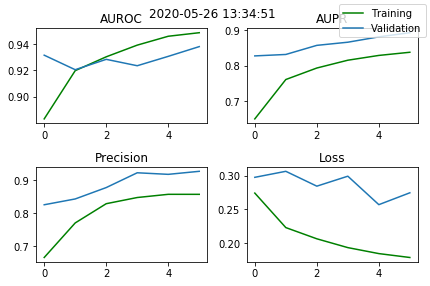

In [6]:
args_t6_sb_A = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 6,
        "hiddenLayers" : 3,
        "unitsPerHL" : 7,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_sb_A, metrics_t6_sb_A = runModel(args_t6_sb_A)
metrics_t6_sb_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_2', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_1'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (45484, 87)
Val set: Done (1166, 87)
Test set: Done (1166, 87)
Train on 45484 samples, validate on 1166 samples
Epoch 1/7
45484/45484 - 6s - loss: 0.2903 - tp: 2879.0000 - fp: 1359.0000 - tn: 37417.0000 - fn: 3829.0000 - accuracy: 0.8859 - precision: 0.6793 - recall: 0.4292 - auroc: 0.8676 - aupr: 0.5915 - val_loss: 0.3422 - val_tp: 134.0000 - val_fp: 23.0000 - val_tn: 858.0000 - val_fn: 151.0000 - val_accuracy: 0.8508 - val_precision: 0.8535 - val_recall: 0.4702 - val_auroc: 0.9104 - val_aupr: 0.8037
Epoch 2/7
45484/45484 - 2s - loss: 0.2395 - tp: 3906.0000 - fp: 1462.0000 - tn: 37314.0000 - fn: 2802.0000 - accuracy: 0.9063 - precision: 0.7276 - recall: 0.5823 - auroc: 0.9106 - aupr: 0.7221 - val_loss: 0.3719 - val_tp: 116.0000 - val_fp: 17.0000 - val_tn: 864.0000 - val_fn: 169.0000 - val_accuracy: 0.8405 - val_precision: 0.8722 - val_recall: 0.4070 - val_auroc: 0.8911 - val_aupr: 0.7887
Epoch 3/7
45484/45484 - 2s - loss: 0.2273 - tp: 3991.0

{'Brier': 0.10227589657991983,
 'Metrics': {'loss': 0.32664020188906795,
  'tp': 142.0,
  'fp': 26.0,
  'tn': 850.0,
  'fn': 148.0,
  'accuracy': 0.85077184,
  'precision': 0.8452381,
  'recall': 0.48965517,
  'auroc': 0.9155389,
  'aupr': 0.8148855}}

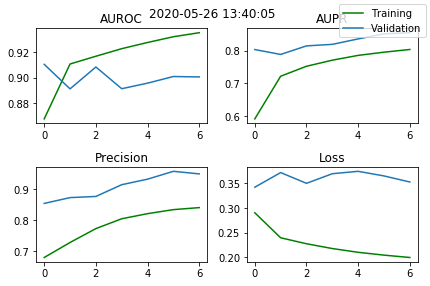

In [12]:
args_t12_sb_A = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 5,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_sb_A, metrics_t12_sb_A = runModel(args_t12_sb_A)
metrics_t12_sb_A

_________ TYP 2 (ns) -----------------------

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_2'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (47310, 87)
Val set: Done (1749, 87)
Test set: Done (1749, 87)
Train on 47310 samples, validate on 1749 samples
Epoch 1/7
47310/47310 - 7s - loss: 0.1937 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44631.0000 - fn: 2679.0000 - accuracy: 0.9434 - precision: 0.0000e+00 - recall: 0.0000e+00 - auroc: 0.7964 - aupr: 0.1486 - val_loss: 0.2392 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1528.0000 - val_fn: 221.0000 - val_accuracy: 0.8736 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auroc: 0.9273 - val_aupr: 0.6194
Epoch 2/7
47310/47310 - 2s - loss: 0.1509 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44631.0000 - fn: 2679.0000 - accuracy: 0.9434 - precision: 0.0000e+00 - recall: 0.0000e+00 - auroc: 0.8924 - aupr: 0.3974 - val_loss: 0.2168 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1528.0000 - val_fn: 221.0000 - val_accuracy: 0.8736 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auroc: 0.9429 - val_aupr: 0.7186
Epoch 

{'Brier': 0.05427023978372417,
 'Metrics': {'loss': 0.17757249584292653,
  'tp': 181.0,
  'fp': 23.0,
  'tn': 1450.0,
  'fn': 95.0,
  'accuracy': 0.93253285,
  'precision': 0.8872549,
  'recall': 0.6557971,
  'auroc': 0.9729861,
  'aupr': 0.86815226}}

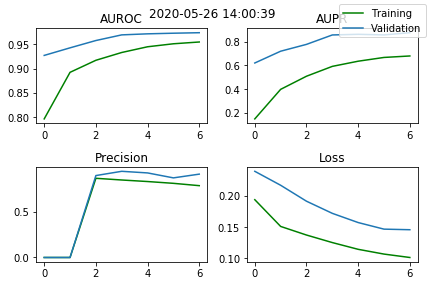

In [14]:



args_t1_ns_A = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 1, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 5,
        "unitsInputLayer" : 5,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t1_ns_A, metrics_t1_ns_A = runModel(args_t1_ns_A)
metrics_t1_ns_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_2'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (46480, 87)
Val set: Done (1484, 87)
Test set: Done (1484, 87)
Train on 46480 samples, validate on 1484 samples
Epoch 1/7
46480/46480 - 6s - loss: 0.1888 - tp: 18.0000 - fp: 77.0000 - tn: 43753.0000 - fn: 2632.0000 - accuracy: 0.9417 - precision: 0.1895 - recall: 0.0068 - auroc: 0.8059 - aupr: 0.1770 - val_loss: 0.2373 - val_tp: 28.0000 - val_fp: 2.0000 - val_tn: 1290.0000 - val_fn: 164.0000 - val_accuracy: 0.8881 - val_precision: 0.9333 - val_recall: 0.1458 - val_auroc: 0.9240 - val_aupr: 0.6492
Epoch 2/7
46480/46480 - 3s - loss: 0.1476 - tp: 389.0000 - fp: 194.0000 - tn: 43636.0000 - fn: 2261.0000 - accuracy: 0.9472 - precision: 0.6672 - recall: 0.1468 - auroc: 0.8959 - aupr: 0.4341 - val_loss: 0.2168 - val_tp: 76.0000 - val_fp: 8.0000 - val_tn: 1284.0000 - val_fn: 116.0000 - val_accuracy: 0.9164 - val_precision: 0.9048 - val_recall: 0.3958 - val_auroc: 0.9408 - val_aupr: 0.7510
Epoch 3/7
46480/46480 - 2s - loss: 0.1352 - tp: 649.0000 - fp:

{'Brier': 0.04765977565231181,
 'Metrics': {'loss': 0.1635776440590379,
  'tp': 174.0,
  'fp': 42.0,
  'tn': 1205.0,
  'fn': 63.0,
  'accuracy': 0.9292453,
  'precision': 0.8055556,
  'recall': 0.73417723,
  'auroc': 0.9740136,
  'aupr': 0.8668825}}

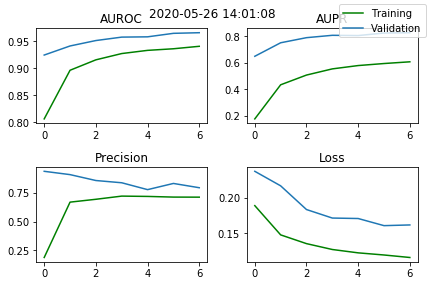

In [15]:



args_t6_ns_A = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 5,
        "unitsInputLayer" : 5,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_ns_A, metrics_t6_ns_A = runModel(args_t6_ns_A)
metrics_t6_ns_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_3', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_2'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (45484, 87)
Val set: Done (1166, 87)
Test set: Done (1166, 87)
Train on 45484 samples, validate on 1166 samples
Epoch 1/7
45484/45484 - 6s - loss: 0.2060 - tp: 0.0000e+00 - fp: 2.0000 - tn: 42864.0000 - fn: 2618.0000 - accuracy: 0.9424 - precision: 0.0000e+00 - recall: 0.0000e+00 - auroc: 0.7620 - aupr: 0.1300 - val_loss: 0.2758 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1013.0000 - val_fn: 153.0000 - val_accuracy: 0.8688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auroc: 0.9108 - val_aupr: 0.4962
Epoch 2/7
45484/45484 - 2s - loss: 0.1625 - tp: 217.0000 - fp: 115.0000 - tn: 42751.0000 - fn: 2401.0000 - accuracy: 0.9447 - precision: 0.6536 - recall: 0.0829 - auroc: 0.8670 - aupr: 0.3454 - val_loss: 0.2502 - val_tp: 39.0000 - val_fp: 22.0000 - val_tn: 991.0000 - val_fn: 114.0000 - val_accuracy: 0.8834 - val_precision: 0.6393 - val_recall: 0.2549 - val_auroc: 0.9197 - val_aupr: 0.5681
Epoch 3/7
45484/45484 - 3s - loss: 0.

{'Brier': 0.06642301039505397,
 'Metrics': {'loss': 0.20320854921654302,
  'tp': 99.0,
  'fp': 18.0,
  'tn': 955.0,
  'fn': 94.0,
  'accuracy': 0.9039451,
  'precision': 0.84615386,
  'recall': 0.51295334,
  'auroc': 0.95496273,
  'aupr': 0.79705036}}

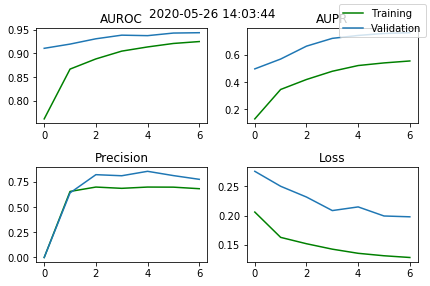

In [17]:
args_t12_ns_A = {
        "targetVar" : "dummy_type_2",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 5,
        "unitsInputLayer" : 5,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_ns_A, metrics_t12_ns_A = runModel(args_t12_ns_A)
metrics_t12_ns_A

TYP 3 ---- (os)

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_3'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (47310, 87)
Val set: Done (1749, 87)
Test set: Done (1749, 87)
Train on 47310 samples, validate on 1749 samples
Epoch 1/7
47310/47310 - 7s - loss: 0.2377 - tp: 2878.0000 - fp: 1595.0000 - tn: 40045.0000 - fn: 2792.0000 - accuracy: 0.9073 - precision: 0.6434 - recall: 0.5076 - auroc: 0.8984 - aupr: 0.6043 - val_loss: 0.1939 - val_tp: 222.0000 - val_fp: 93.0000 - val_tn: 1380.0000 - val_fn: 54.0000 - val_accuracy: 0.9160 - val_precision: 0.7048 - val_recall: 0.8043 - val_auroc: 0.9569 - val_aupr: 0.8635
Epoch 2/7
47310/47310 - 3s - loss: 0.1883 - tp: 3413.0000 - fp: 1390.0000 - tn: 40250.0000 - fn: 2257.0000 - accuracy: 0.9229 - precision: 0.7106 - recall: 0.6019 - auroc: 0.9410 - aupr: 0.7202 - val_loss: 0.1789 - val_tp: 221.0000 - val_fp: 76.0000 - val_tn: 1397.0000 - val_fn: 55.0000 - val_accuracy: 0.9251 - val_precision: 0.7441 - val_recall: 0.8007 - val_auroc: 0.9583 - val_aupr: 0.8772
Epoch 3/7
47310/47310 - 3s - loss: 0.1734 - tp: 3552.0

{'Brier': 0.06705086643915123,
 'Metrics': {'loss': 0.23013208451025347,
  'tp': 285.0,
  'fp': 28.0,
  'tn': 1311.0,
  'fn': 125.0,
  'accuracy': 0.9125214,
  'precision': 0.91054314,
  'recall': 0.69512194,
  'auroc': 0.9486357,
  'aupr': 0.88746345}}

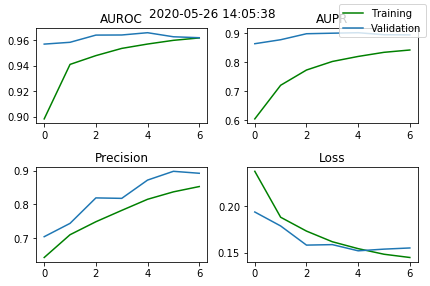

In [18]:



args_t1_os_A = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 1, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t1_os_A, metrics_t1_os_A = runModel(args_t1_os_A)
metrics_t1_os_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_3'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (46480, 87)
Val set: Done (1484, 87)
Test set: Done (1484, 87)
Train on 46480 samples, validate on 1484 samples
Epoch 1/7
46480/46480 - 6s - loss: 0.2461 - tp: 2463.0000 - fp: 1827.0000 - tn: 39068.0000 - fn: 3122.0000 - accuracy: 0.8935 - precision: 0.5741 - recall: 0.4410 - auroc: 0.8907 - aupr: 0.5667 - val_loss: 0.2273 - val_tp: 186.0000 - val_fp: 92.0000 - val_tn: 1147.0000 - val_fn: 59.0000 - val_accuracy: 0.8982 - val_precision: 0.6691 - val_recall: 0.7592 - val_auroc: 0.9446 - val_aupr: 0.8127
Epoch 2/7
46480/46480 - 2s - loss: 0.1948 - tp: 3251.0000 - fp: 1508.0000 - tn: 39387.0000 - fn: 2334.0000 - accuracy: 0.9173 - precision: 0.6831 - recall: 0.5821 - auroc: 0.9351 - aupr: 0.7026 - val_loss: 0.2084 - val_tp: 182.0000 - val_fp: 68.0000 - val_tn: 1171.0000 - val_fn: 63.0000 - val_accuracy: 0.9117 - val_precision: 0.7280 - val_recall: 0.7429 - val_auroc: 0.9479 - val_aupr: 0.8303
Epoch 3/7
46480/46480 - 2s - loss: 0.1848 - tp: 3400.0

{'Brier': 0.09499352395348012,
 'Metrics': {'loss': 0.3159629748506607,
  'tp': 197.0,
  'fp': 40.0,
  'tn': 1088.0,
  'fn': 159.0,
  'accuracy': 0.86590296,
  'precision': 0.8312236,
  'recall': 0.5533708,
  'auroc': 0.9256066,
  'aupr': 0.8065363}}

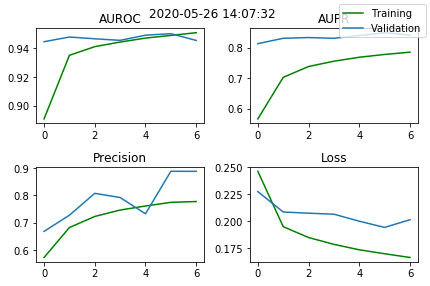

In [19]:




args_t6_os_A = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 6, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t6_os_A, metrics_t6_os_A = runModel(args_t6_os_A)
metrics_t6_os_A

Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'dummy_type_3', 'nb_type_1',
       'nb_type_2', 'nb_type_3', 'nb_deaths', 'dummy_nb_type_1',
       'dummy_nb_type_2', 'dummy_nb_type_3', 'v2x_regime', 'e_wb_pop',
       'e_miferrat', 'e_peaveduc', 'e_area', 'e_pelifeex', 'e_peinfmor',
       'v2x_clphy', 'v2x_rule', 'e_regiongeo', 'e_migdpgro', 'e_migdppc',
       'e_cow_exports', 'e_cow_imports', 'e_pt_coup'],
      dtype='object')
Index(['month', 'country_id', 'type_1', 'type_2', 'type_3', 'deaths',
       'dummy_type_1', 'dummy_type_2', 'nb_type_1', 'nb_type_2', 'nb_type_3',
       'nb_deaths', 'dummy_nb_type_1', 'dummy_nb_type_2', 'dummy_nb_type_3',
       'v2x_regime', 'e_wb_pop', 'e_miferrat', 'e_peaveduc', 'e_area',
       'e_pelifeex', 'e_peinfmor', 'v2x_clphy', 'v2x_rule', 'e_regiongeo',
       'e_migdpgro', 'e_migdppc', 'e_cow_exports', 'e_cow_imports',
       'e_pt_coup', 'dummy_type_3'],
      dtype='object')
    

[5976 rows x 31 columns]
Training set: Done (45484, 87)
Val set: Done (1166, 87)
Test set: Done (1166, 87)
Train on 45484 samples, validate on 1166 samples
Epoch 1/7
45484/45484 - 5s - loss: 0.2538 - tp: 2134.0000 - fp: 1287.0000 - tn: 38723.0000 - fn: 3340.0000 - accuracy: 0.8983 - precision: 0.6238 - recall: 0.3898 - auroc: 0.8786 - aupr: 0.5460 - val_loss: 0.2664 - val_tp: 127.0000 - val_fp: 26.0000 - val_tn: 934.0000 - val_fn: 79.0000 - val_accuracy: 0.9099 - val_precision: 0.8301 - val_recall: 0.6165 - val_auroc: 0.9112 - val_aupr: 0.7925
Epoch 2/7
45484/45484 - 2s - loss: 0.2056 - tp: 3029.0000 - fp: 1464.0000 - tn: 38546.0000 - fn: 2445.0000 - accuracy: 0.9141 - precision: 0.6742 - recall: 0.5533 - auroc: 0.9262 - aupr: 0.6743 - val_loss: 0.2558 - val_tp: 115.0000 - val_fp: 28.0000 - val_tn: 932.0000 - val_fn: 91.0000 - val_accuracy: 0.8979 - val_precision: 0.8042 - val_recall: 0.5583 - val_auroc: 0.9261 - val_aupr: 0.8006
Epoch 3/7
45484/45484 - 2s - loss: 0.1977 - tp: 3077.000

{'Brier': 0.0861638464608112,
 'Metrics': {'loss': 0.2831072439479531,
  'tp': 158.0,
  'fp': 13.0,
  'tn': 868.0,
  'fn': 127.0,
  'accuracy': 0.8799314,
  'precision': 0.9239766,
  'recall': 0.55438596,
  'auroc': 0.9357648,
  'aupr': 0.8553278}}

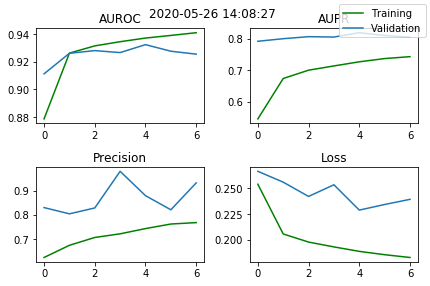

In [20]:





args_t12_os_A = {
        "targetVar" : "dummy_type_3",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 1,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_os_A, metrics_t12_os_A = runModel(args_t12_os_A)
metrics_t12_os_A

In [ ]:
args_t3 = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 15,
        "hiddenLayers" : 2,
        "unitsPerHL" : 11,
        "unitsInputLayer" : 11,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

In [ ]:
#Bra skit

args_t3 = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : True,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 6,
        #Antalet förskjutningar.
        "nShifts" : 3, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

In [ ]:
args_t12_sb_G = {
        "targetVar" : "dummy_type_1",
        "onlyAfricaTest" : False,
        "onlyAfricaVal" : False,
        "onlyAfricaTrain" : False,
        #Storleken på fönstret som ska inkluderas i ett sample.
        "windowSize" : 3,
        #Antalet förskjutningar.
        "nShifts" : 12, 
        "epochs" : 7,
        "hiddenLayers" : 2,
        "unitsPerHL" : 6,
        "unitsInputLayer" : 6,
        #Blanda samples?
        "shuffle" : True,
        "batch_size" : 40,
        "timeStamp" : strftime("%Y-%m-%d %H:%M:%S", localtime()),
        "kerasTuner": False
}

model_t12_sb_G, metrics_t12_sb_G = runModel(args_t12_sb_G)
metrics_t12_sb_G